### 《28天玩转TensorFlow2》第12天：TensorFlow2项目实战—基于LSTM和GRU的股票预测

## 一、RNN简介

Recurrent Neural Network(循环神经网络)是可处理序列或者时间序列数据的神经网络，该模型在时间序列预测以及NLP(自然语言处理)领域应用较多。循环神经网络的变体较多，下面给出其最简单的形式。

In [1]:
%%html
<img src='12.01.png', width=800>

从上图可以看出，非RNN神经网络中，训练样本之间在模型训练期间是没有联系的。而RNN神经网络中，当前这条训练数据的隐层输出有一部分是由前一条训练数据的隐层输出决定的，而当前条的隐层输出同样会影响下一条的隐层输出，这样就建立起训练样本之间的联系。训练的时候，网络会把当前时刻隐层的输出存下来（这个输出也就是隐层的状态），到训练下一时刻数据的时候再拿出来用。对于RNN，除了训练输入层到隐层的，以及隐层到下一个隐层的，隐层到输出层的参数矩阵，还要训练隐层到自身层的参数矩阵。

RNN在训练中很容易发生梯度爆炸和梯度消失，前者可以通过设计梯度阈值的方式来解决。梯度消失出现时，就是说明模型只学习到最近时刻对当前时刻的影响，也就是对短期输入比较敏感，而更早时刻的影响趋近于0，解决这个问题可使用其他结构的RNN，比如LSTM和GRU来解决。

### 1、LSTM简介

Hochreiter和Schmidhuber两位科学家1997年发明出长短时记忆网络(Long Short-Term Memory,LSTM)，该结构思路比较简单：原始RNN的隐层只有一个状态，定义为h(隐藏状态)，它对于短期的输入非常敏感。现在再增加一个状态c(细胞状态)，让它来保存针对长期的记忆：

In [2]:
%%html
<img src='12.02.png', width=800>

LSTM的关键，就是怎样控制长期状态c。思路是使用3个控制开关：
+ 1 遗忘门：控制继续保存长期状态c；
+ 2 输入门：控制把当前状态输入到长期状态c；
+ 3 输出门：控制是否把长期状态c作为输出。3个开关的作用如上图(右)所示。

开关通过“门”来实现，它就是一个全连接层，输出0到1之间的实数组成的向量。下面给出三个门的计算表达图示：

In [3]:
%%html
<img src='12.03.png', width=800>

### 2、GRU简介

LSTM存在很多变体，在众多的LSTM变体中，GRU(门控循环单元,Gated Recurrent Unit)可以说是最成功的。它结构比LSTM简单，训练速度快，效果和LSTM不相上下。GRU对LSTM做了两个大改动：
+ 1 将3门变为2门：更新门和重置门；
+ 2 将细胞状态与输出合并为一个状态h。

更新门的作用类似于LSTM的遗忘和输入门，它决定要丢弃哪些信息和添加哪些信息。重置门是另一个用来决定要忘记多少过去的信息的门。结构如下：

In [4]:
%%html
<img src='12.04.png', width=600>

## 二、程序实现

## 0 运行环境

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import sys
import shutil
import time 
import os
print('numpy版本：', np.__version__) # 版本为1.18.5 高了报错
print('python版本：', sys.version)
print('tensorlfow版本:',tf.__version__)
print('可用GPU数量:', len(tf.config.experimental.list_physical_devices('GPU')))
print('GPU显卡信息:')
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

numpy版本： 1.18.5
python版本： 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
tensorlfow版本: 2.2.0
可用GPU数量: 1
GPU显卡信息:
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## 1 数据说明

2013-2018年全球505家上市公司的每日股票价格数据。数据特征包括日期，开盘价，最高价，最低价，收市价，交易量以及公司股票代码。本文要预测未来5天的股票的收市价以及交易量。

In [6]:
# 数据
STOCK_DATA = pd.read_csv('all_stocks_5yr.csv')
STOCK_DATA.head(3)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL


In [7]:
# 本文研究的公司
COMPANY_STOCK = {'苹果':'AAPL','亚马逊':'AMZN','谷歌':'GOOGL','微软':'MSFT'}

# 根据股票代码获得数据
def get_data(sname, sdata=STOCK_DATA):
    stock_data = sdata[sdata['Name']==sname]
    # 将日期列转化为日期格式
    c_stock_data =stock_data.copy()
    c_stock_data.loc[:, 'date'] = pd.to_datetime(stock_data['date'])
    # 按日期升序排列
    c_stock_data.sort_values('date', ascending=True,inplace=True)
    return c_stock_data

In [36]:
# 数据源
COMPANT_NAME = '亚马逊'
model_data = get_data(COMPANY_STOCK[COMPANT_NAME])
model_data

,date,open,high,low,close,volume,Name
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN
...,...,...,...,...,...,...,...
47641,2018-02-01,1445.00,1459.88,1385.140,1390.00,9113808,AMZN
47642,2018-02-02,1477.39,1498.00,1414.000,1429.95,11125722,AMZN
47643,2018-02-05,1402.62,1458.98,1320.720,1390.00,11494985,AMZN
47644,2018-02-06,1361.46,1443.99,1351.790,1442.84,11066819,AMZN


## 2 特征工程

In [37]:
# 构建特征工程
def build_feature(exdf):
    c_exdf = exdf.copy()
    # 将日期的年月周几提取出来
    c_exdf.loc[:, '月']  = c_exdf['date'].dt.month
    c_exdf.loc[:, '日'] = c_exdf['date'].dt.day
    c_exdf.loc[:, '星期']  = c_exdf['date'].dt.weekday+1
    
    # 价格特征
    c_exdf['High-Low'] = c_exdf['high'] - c_exdf['low']
    c_exdf['High/Low'] = c_exdf['high'] / c_exdf['low']
    
    c_exdf['Close/Open'] = c_exdf['close'] / c_exdf['open']
    c_exdf['Close-Open'] = c_exdf['close'] - c_exdf['open']
    
    c_exdf['Mean'] = c_exdf[['open', 'high', 'low', 'close']].mean(axis=1)
    c_exdf['High/Mean'] = c_exdf['high'] / c_exdf['Mean']
    c_exdf['Low/Mean'] = c_exdf['low'] / c_exdf['Mean']
    
    c_exdf['Median'] = c_exdf[['open', 'high', 'low', 'close']].median(axis=1)
    c_exdf['High/Median'] = c_exdf['high'] / c_exdf['Median']
    c_exdf['Low/Median'] = c_exdf['low'] / c_exdf['Median']
    
    return c_exdf

In [38]:
feature_data = build_feature(model_data)
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 46387 to 47645
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1259 non-null   datetime64[ns]
 1   open         1259 non-null   float64       
 2   high         1259 non-null   float64       
 3   low          1259 non-null   float64       
 4   close        1259 non-null   float64       
 5   volume       1259 non-null   int64         
 6   Name         1259 non-null   object        
 7   月            1259 non-null   int64         
 8   日            1259 non-null   int64         
 9   星期           1259 non-null   int64         
 10  High-Low     1259 non-null   float64       
 11  High/Low     1259 non-null   float64       
 12  Close/Open   1259 non-null   float64       
 13  Close-Open   1259 non-null   float64       
 14  Mean         1259 non-null   float64       
 15  High/Mean    1259 non-null   float64       
 16  L

## 3 构建数据集

In [39]:
# 利用前PAST_DAYS天（包括今天）的数据，预测未来FUTURE_DAYS天（明天开始）的收盘价和交易量。
PAST_DAYS = 7
FUTURE_DAYS = 7

In [40]:
# 特征列
FEATURE = ['open','high','low','High-Low','High/Low',
          'Close/Open','Close-Open','Mean','High/Mean','Low/Mean',
          'Median','High/Median','Low/Median','月','日','星期']
# 目标列
TARGET = ['close','volume']

#### 所以用于模型训练的输入数据：

 + 目标列的过去PAST_DAYS数据
 + 特征列的过去PAST_DAYS数据
 
#### 输出数据：
 
 + 特征列的未来FUTURE_DAYS数据
 
针对时间序列数据模型，为了防止数据泄露问题导致的线上效果好，实际部署效果差：
 + 1 数据集需要按照时间序列顺序进行分割；
 + 2 根据训练数据集的值对三个数据集进行最小最大归一化；
 
除此之外，每个目标特征单独训练，也就是模型包括多个输入。本例中两个目标特征的输入数据是一样的。

In [41]:
# 按照时间顺序和一定比例切割数据集
def split_data(df, train_p=0.7, val_p=0.2, feature=FEATURE, target=TARGET, pdays=PAST_DAYS, fdays=FUTURE_DAYS):
    # 数据集
    n = len(df)
    train_df = df[0:int(n*train_p)]  # 训练
    val_df = df[int(n*train_p):int(n*(train_p+val_p))] # 验证
    test_df = df[int(n*(train_p+val_p)):] # 测试

    # 开始进行标准化
    #存入字典
    feature_dict = {}
    for k in feature+target:
        f_data = train_df[k].values # 训练数据集
        min_n, max_n = np.min(f_data), np.max(f_data)
        # 记录
        feature_dict[k] = {'min':min_n, 'max':max_n}
    
    # 开始标准化
    def trans_data(df, exdict=feature_dict):
        c_df = df.copy()
        for k in exdict:
            c_df[k] = (df[k] - exdict[k]['min']) / (exdict[k]['max'] - exdict[k]['min'])
        return c_df
    
    # 标准化
    train_df_n = trans_data(train_df)
    val_df_n = trans_data(val_df)
    test_df_n = trans_data(test_df)
    
    # 开始构建输入和输出
    def split_in_out(exdf, f=feature, t=target, pds=pdays, fds=fdays):
        in_data = [] # 输入数据
        out_data = [] # 输出数据
        l = len(exdf)  # 所有数据的长度
        need_data_f = exdf[f+t].values  # 全部特征数据
        need_data_t = exdf[t].values  # 全部输出数据
        
        # 构建输入
        for s in range(l-fds-pds+1):
            # 特征数据
            indata = need_data_f[s:(s+pds)]
            in_data.append(indata)
            
        # 构建输出
        for s in range(pds,l-fds+1):
            # 特征数据
            outdata = need_data_t[s:(s+fds)]
            out_data.append(outdata)
            
        return np.array(in_data), np.array(out_data)

    # 将数据分割为输入和输出
    x_train, y_train =  split_in_out(train_df_n)   
    x_val, y_val = split_in_out(val_df_n) 
    x_test, y_test = split_in_out(test_df_n) 
    
    return x_train, y_train,x_val, y_val,x_test, y_test,feature_dict

In [42]:
# 数据集的输入输出以及字典
X_train, Y_train, X_val, Y_val, X_test, Y_test, Feature_dict = split_data(feature_data)

## 4 构建模型

In [43]:
In_shape = X_train.shape
Out_shape = Y_train.shape

print(In_shape, Out_shape)
# 每个特征单独的LSTM/GRU层
def tf2_model(inshp, outshp, func, name='af'):
    close_input = tf.keras.Input(shape=inshp, name='close_input') # 收市价
    volume_input = tf.keras.Input(shape=inshp, name='volume_input') # 交易量
    
    # LSTM/GRU 层
    x_close = func(356,name='lstm_c',return_sequences=False,recurrent_activation='sigmoid',
                   activation='tanh',recurrent_dropout=0)(close_input)
    x_volume = func(356,name='lstm_v',return_sequences=False,recurrent_activation='sigmoid',
                    activation='tanh',recurrent_dropout=0)(volume_input)
    
    # 融合层
    x_merge = tf.keras.layers.concatenate([x_close, x_volume])
    
    # 全连接层
    x_dense = tf.keras.layers.Dense(outshp[0]*outshp[1], name='dense',kernel_initializer=tf.initializers.zeros())(x_merge)
    # 转换维度层
    x_out = tf.keras.layers.Reshape(outshp, name='reshape')(x_dense)

    #  建立模型
    lstm_model = tf.keras.Model(inputs=[close_input, volume_input], outputs=x_out, name=name)
    # 模型编译
    lstm_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse',metrics=[tf.metrics.MeanAbsolutePercentageError()])
    # 模型信息
    lstm_model.summary()
    return lstm_model
 

(868, 7, 18) (868, 7, 2)


In [44]:
# 训练模型的参数
def train_model_lstm_gru(modelpath, model, X_train, Y_train, X_val, Y_val, ltn, lvn, bs=8, e=30):
    # 建立存储模型参数的文件夹
    log_dir = '%s/%s' % (modelpath, int(time.time()))

    #  建立文件夹
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    else:
        shutil.rmtree(log_dir)
        os.mkdir(log_dir)
 
    # 检查点文件中包含验证数据集误差和epoch，此时新保存的模型不会覆盖以前的
    # 下面设置就会覆盖，
    checkpoint_path = "%s/best_model.ckpt" % log_dir

    # 创建一个回调，保证验证数据集误差最小，每一个epoch，只要验证数据集的误差变小，就会保存
    # 只保存权重，不保存模型结构，这样，在调用模型的时候，需要重新加载模型结构
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True, monitor='val_loss',
                                                     mode='min', verbose=1, save_best_only=True)
    # 记录训练过程
    model_history = model.fit([X_train, X_train],Y_train,epochs=e,
                              validation_data=([X_val,X_val], Y_val), callbacks=[cp_callback])
    
   
    return model_history,checkpoint_path

## 5 模型训练保存

In [45]:
# 模型的输入、输出维度
inshp = tuple(In_shape[-2:])
outshp = tuple(Y_train.shape[-2:])

# 保存最佳模型的路径
BEST_MODEL_DICT = {}

### 5.1 LSTM

In [46]:
# 存储LSYM模型的路径
SAVE_MODEL_PATH_LSTM =  r'D:\GWTWORK\Tensorflow_time28\LSTM_MODEL'
# 构建LSTM模型
kp_model = tf2_model(inshp, outshp, tf.keras.layers.LSTM, name='lstm-af')
#  建立存储模型的文件夹
if not os.path.exists(SAVE_MODEL_PATH_LSTM):
    os.makedirs(SAVE_MODEL_PATH_LSTM)
else:
    shutil.rmtree(SAVE_MODEL_PATH_LSTM)
    os.mkdir(SAVE_MODEL_PATH_LSTM)
# 训练
train_his, train_model_path = train_model_lstm_gru(SAVE_MODEL_PATH_LSTM, kp_model, X_train, Y_train, X_val, Y_val, len(X_train), len(X_val))
# 保存最佳模型
BEST_MODEL_DICT['LSTM'] = train_model_path

Model: "lstm-af"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
close_input (InputLayer)        [(None, 7, 18)]      0                                            
__________________________________________________________________________________________________
volume_input (InputLayer)       [(None, 7, 18)]      0                                            
__________________________________________________________________________________________________
lstm_c (LSTM)                   (None, 356)          534000      close_input[0][0]                
__________________________________________________________________________________________________
lstm_v (LSTM)                   (None, 356)          534000      volume_input[0][0]               
____________________________________________________________________________________________

27/28 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_absolute_percentage_error: 101246.1250
Epoch 00017: val_loss did not improve from 0.00386
28/28 [==============================] - 1s 46ms/step - loss: 0.0050 - mean_absolute_percentage_error: 100779.7031 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 30.7643
Epoch 18/30
27/28 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_absolute_percentage_error: 93443.6328
Epoch 00018: val_loss did not improve from 0.00386
28/28 [==============================] - 1s 46ms/step - loss: 0.0052 - mean_absolute_percentage_error: 93013.2578 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 34.3443
Epoch 19/30
27/28 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_absolute_percentage_error: 109390.2422
Epoch 00019: val_loss did not improve from 0.00386
28/28 [==============================] - 1s 46ms/step - loss: 0.0050 - mean_absolute_percentage_error: 108886.3203 - val_loss: 0.0044 -

### 5.2 GRU

In [47]:
##################GRU模型##################################
# 存储LSYM模型的路径
SAVE_MODEL_PATH_GRU =  r'D:\GWTWORK\Tensorflow_time28\GRU_MODEL'
# 构建GRU模型
kp_model = tf2_model(inshp, outshp, tf.keras.layers.GRU, name='gru-af')
#  建立存储模型的文件夹
 
if not os.path.exists(SAVE_MODEL_PATH_GRU):
    os.makedirs(SAVE_MODEL_PATH_GRU)
else:
    shutil.rmtree(SAVE_MODEL_PATH_GRU)
    os.mkdir(SAVE_MODEL_PATH_GRU)
# 训练
train_his, train_model_path = train_model_lstm_gru(SAVE_MODEL_PATH_GRU, kp_model, X_train, Y_train, X_val, Y_val, len(X_train), len(X_val))
BEST_MODEL_DICT['GRU'] = train_model_path

Model: "gru-af"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
close_input (InputLayer)        [(None, 7, 18)]      0                                            
__________________________________________________________________________________________________
volume_input (InputLayer)       [(None, 7, 18)]      0                                            
__________________________________________________________________________________________________
lstm_c (GRU)                    (None, 356)          401568      close_input[0][0]                
__________________________________________________________________________________________________
lstm_v (GRU)                    (None, 356)          401568      volume_input[0][0]               
_____________________________________________________________________________________________

27/28 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_absolute_percentage_error: 101834.0703
Epoch 00017: val_loss did not improve from 0.00406
28/28 [==============================] - 1s 39ms/step - loss: 0.0049 - mean_absolute_percentage_error: 101364.9844 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 45.9736
Epoch 18/30
27/28 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_absolute_percentage_error: 100723.7969
Epoch 00018: val_loss did not improve from 0.00406
28/28 [==============================] - 1s 40ms/step - loss: 0.0050 - mean_absolute_percentage_error: 100259.8047 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 49.5743
Epoch 19/30
27/28 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_absolute_percentage_error: 94687.6797
Epoch 00019: val_loss did not improve from 0.00406
28/28 [==============================] - 1s 38ms/step - loss: 0.0050 - mean_absolute_percentage_error: 94251.5938 - val_loss: 0.0044 -

## 6 模型效果评估

2个模型3个数据集的2个预测变量的MAPE，皮尔逊系数以及对比曲线.每一天的预测值为一条曲线。

In [48]:
from scipy.stats import pearsonr as pr
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

In [59]:
# 模型预测
def model_predict(xdata, ydata, modeldict, modelstr, modelfunc=tf2_model):
    # 最好的模型
    model_path = modeldict[modelstr]
    # 模型结构
    model_s = modelfunc(xdata.shape[-2:], ydata.shape[-2:], eval('tf.keras.layers.%s' % modelstr))
    # 导入最佳参数
    best_p = tf.train.latest_checkpoint(os.path.abspath(os.path.dirname(model_path)))
    model_s.load_weights(best_p).expect_partial()
    # 开始预测
    model_output = model_s.predict([xdata,xdata])
    # 按照天数组合数据:预测第一天，预测第二天，等等
    idays_dict = {}
    for idays in range(len(model_output[0])):
        idays_dict[idays] = []
        for kda in model_output:
            idays_dict[idays].append(kda[idays])
    return idays_dict

# 将预测数据还原成原始尺度,特征名为字典：数据为df格式
def back_data(exdict, ydata, fdict=Feature_dict,t=TARGET):
    data_df_dict = {}
    for kin, kva in enumerate(t):
        min_n, max_n = fdict[kva]['min'],fdict[kva]['max']
        f_df = pd.DataFrame()
        # 获取对应的列的数据;取每个样本的第一个值
        oridata = []
        for k in ydata[:-1]:
            oridata.append(k[0][kin])
        for kj in ydata[-1]:
            oridata.append(kj[kin])
        # 还原
        ori_real_data = [i * (max_n-min_n)+ min_n for i in oridata]
        f_df['原始%s' % kva] = ori_real_data
        
        # 在存储预测第几天的预测值
        for kp in exdict:
            # 预测值
            pre_data = [] + [np.nan] * kp
            for kpin in exdict[kp]:
                pre_data.append(kpin[kin])
            pre_data += [np.nan] * (len(exdict)-kp-1)
            f_df['预测%s天' % (kp+1)] = [i * (max_n-min_n)+ min_n for i in pre_data]
        data_df_dict[kva] = f_df
    return data_df_dict

# 计算MAPE,皮尔逊系数
def get_judge(ydata, ydata1):
    # 获取公共部分
    new_y = []
    new_y1 = []
    for kin, kva in enumerate(list(ydata)):
        if not np.isnan(ydata1[kin]):
            new_y.append(kva)
            new_y1.append(ydata1[kin])
            
    def mape(y_true,y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
    
    mape_n = mape(new_y, new_y1)
    p_n = pr(new_y, new_y1)
    return ['%.2f%%' % mape_n, '%.2f' % p_n[0]]
    
# 绘图函数
def plot_figure(xdata, ydata, title_name='训练',modeldict=BEST_MODEL_DICT, t=TARGET):
    # 模型对比图
    fig, axs = plt.subplots(2, 2, figsize=(18,10)) 
    for kin, kva in enumerate(['LSTM','GRU']):
        # 获取预测数据
        idays_dict = model_predict(xdata, ydata, modeldict,kva)
        # 获得还原数据
        data_df_dict = back_data(idays_dict, ydata)
        # 开始绘制
        for dkin, dkva in enumerate(t):
            # 绘图：上边是LSTM，下边是GRU 的模型结果
            df_dk = data_df_dict[dkva] 
            for jk in df_dk:
                if '原始' not in jk:
                    mape_n, p_n = get_judge(df_dk['原始%s'%dkva].values,df_dk[jk].values)
                    axs[kin,dkin].plot(df_dk[jk],label=jk+'mape:{},r:{}'.format(mape_n, p_n))
                else:
                    axs[kin,dkin].plot(df_dk[jk],label=jk)
            axs[kin, dkin].set_title(kva+'-'+dkva)  
            axs[kin, dkin].legend(fontsize=14)
    plt.suptitle(title_name)
    plt.legend()
    plt.show()

Model: "af"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
close_input (InputLayer)        [(None, 7, 18)]      0                                            
__________________________________________________________________________________________________
volume_input (InputLayer)       [(None, 7, 18)]      0                                            
__________________________________________________________________________________________________
lstm_c (LSTM)                   (None, 356)          534000      close_input[0][0]                
__________________________________________________________________________________________________
lstm_v (LSTM)                   (None, 356)          534000      volume_input[0][0]               
_________________________________________________________________________________________________

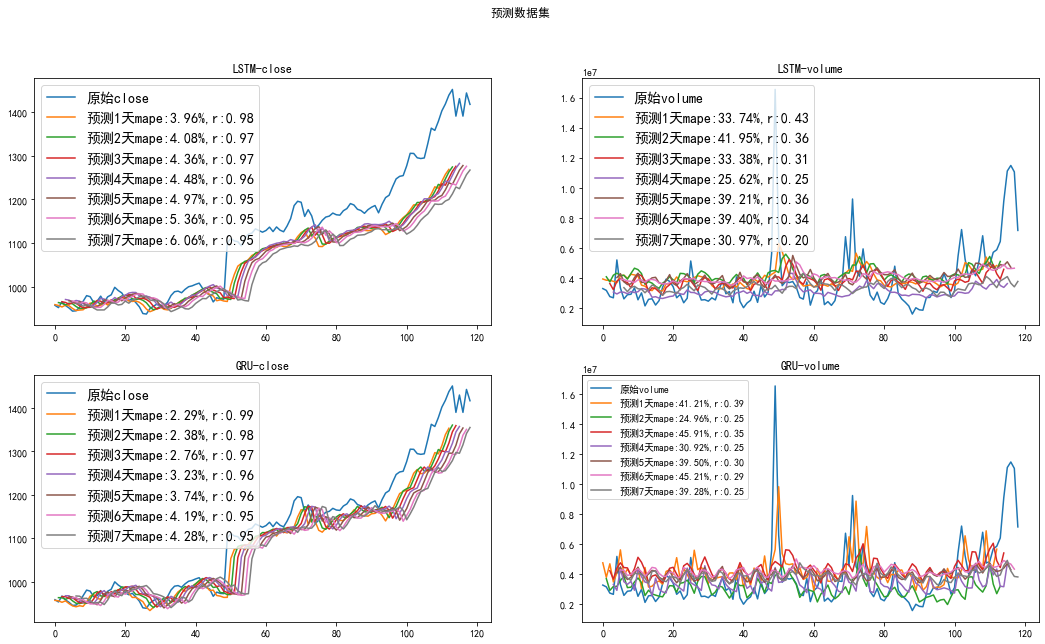

In [60]:
plot_figure(X_test, Y_test,'预测数据集')

Model: "af"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
close_input (InputLayer)        [(None, 7, 18)]      0                                            
__________________________________________________________________________________________________
volume_input (InputLayer)       [(None, 7, 18)]      0                                            
__________________________________________________________________________________________________
lstm_c (LSTM)                   (None, 356)          534000      close_input[0][0]                
__________________________________________________________________________________________________
lstm_v (LSTM)                   (None, 356)          534000      volume_input[0][0]               
_________________________________________________________________________________________________

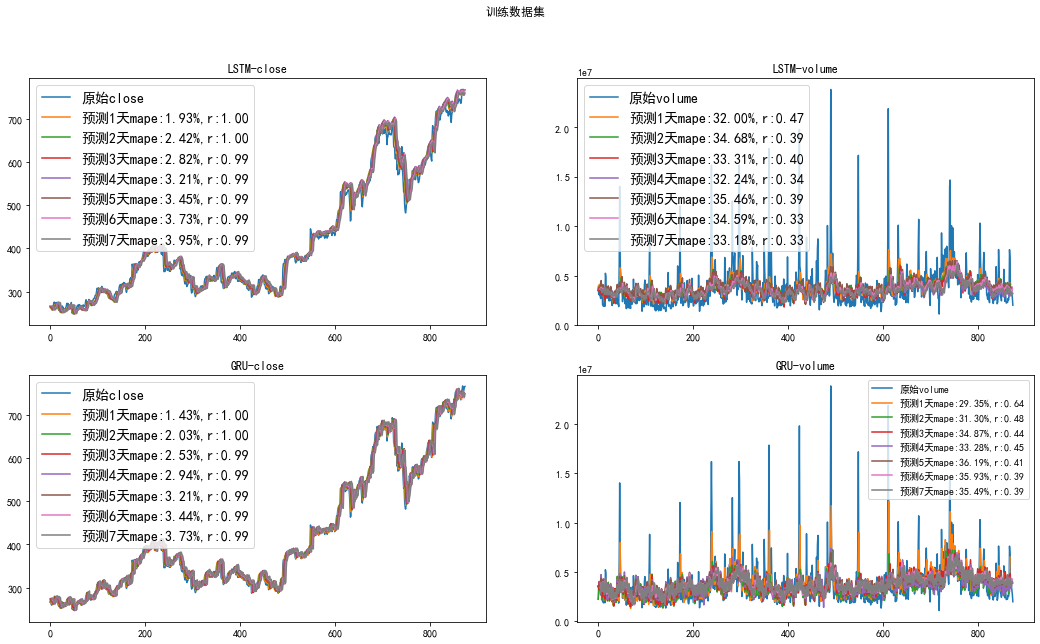

In [61]:
plot_figure(X_train, Y_train,'训练数据集')

Model: "af"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
close_input (InputLayer)        [(None, 7, 18)]      0                                            
__________________________________________________________________________________________________
volume_input (InputLayer)       [(None, 7, 18)]      0                                            
__________________________________________________________________________________________________
lstm_c (LSTM)                   (None, 356)          534000      close_input[0][0]                
__________________________________________________________________________________________________
lstm_v (LSTM)                   (None, 356)          534000      volume_input[0][0]               
_________________________________________________________________________________________________

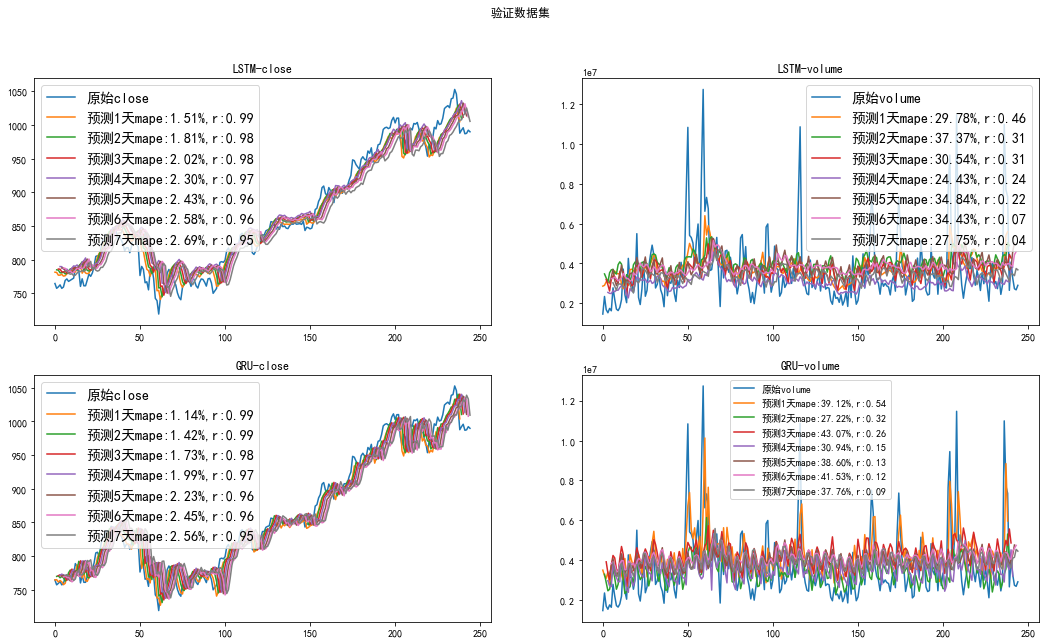

In [62]:
plot_figure(X_val, Y_val,'验证数据集')